In [27]:
import time
import random
import datetime
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Dropout, MaxPool2D,
    Flatten, Dense, Input, Concatenate, LeakyReLU, Add, GlobalAveragePooling2D, Activation,
    MaxPooling2D
)

# LOAD LIBRARIES
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
#from tf.keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler

from tensorflow.keras.layers import BatchNormalization

# How to check if Keras is using GPU?

#from tf.keras import backend as K

#K.tensorflow_backend._get_available_gpus()

train = pd.read_csv('./data/train.csv')
test  = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/submission.csv')

In [28]:
X_train = (train[[str(i) for i in range(784)]] / 255.).values.reshape(-1, 28, 28, 1)
y_train = tf.keras.utils.to_categorical(train['digit'].values)

In [29]:
X_test = (test[[str(i) for i in range(784)]] / 255.).values.reshape(-1, 28, 28, 1)
y_test = tf.keras.utils.to_categorical(train['digit'].values)

In [30]:
# 아마 성능 향상의 가장 큰 요인, 데이터 증강
# CREATE MORE IMAGES VIA DATA AUGMENTATION
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [31]:
# Create the base model from the pre-trained model VGG16
def create_cnn_model(x_train):
    inputs = tf.keras.layers.Input(x_train.shape[1:])

    bn = BatchNormalization()(inputs)
    conv = Conv2D(128, kernel_size=5, strides=1, padding='same', activation='elu')(bn)
    bn = BatchNormalization()(conv)
    conv = Conv2D(128, kernel_size=2, strides=1, padding='same', activation='elu')(bn)
    pool = MaxPooling2D((2, 2))(conv)

    bn = BatchNormalization()(pool)
    conv = Conv2D(256, kernel_size=2, strides=1, padding='same', activation='elu')(bn)
    bn = BatchNormalization()(conv)
    conv = Conv2D(256, kernel_size=2, strides=1, padding='same', activation='elu')(bn)
    pool = MaxPooling2D((2, 2))(conv)
    
    bn = BatchNormalization()(pool)
    conv = Conv2D(512, kernel_size=2, strides=1, padding='same', activation='elu')(bn)
    bn = BatchNormalization()(conv)
    conv = Conv2D(5122, kernel_size=2, strides=1, padding='same', activation='elu')(bn)
    pool = MaxPooling2D((2, 2))(conv)

    flatten = Flatten()(pool)

    bn = BatchNormalization()(flatten)
    dense = Dense(1000, activation='elu')(bn)
    drop = Dropout(0.5)(dense)
    
    bn = BatchNormalization()(drop)
    dense = Dense(256, activation='elu')(bn)
    drop = Dropout(0.5)(dense)

    bn = BatchNormalization()(drop)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(bn)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    return model


In [32]:
model = create_cnn_model(X_train)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 128)       3328      
_________________________________________________________________
batch_normalization_13 (Batc (None, 28, 28, 128)       512       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 128)       65664     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 14, 14, 128)       512 

In [33]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

In [34]:
print(X_train.shape)
print(y_train.shape)

(2048, 28, 28, 1)
(2048, 10)


In [35]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Nadam(lr=base_learning_rate),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [36]:
epochs =5
batch_size = 86
# Train-Test를 9:1로 분리
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train, y_train, test_size = 0.1)

history = model.fit_generator(
    datagen.flow(X_train2, y_train2, batch_size=batch_size),
    epochs=epochs, 
    steps_per_epoch=1000,
    validation_data=(X_val2, y_val2), 
    callbacks=[annealer], 
    verbose=2
)

Epoch 1/5
1000/1000 - 160s - loss: 0.6814 - accuracy: 0.7711 - val_loss: 0.7562 - val_accuracy: 0.7707 - lr: 0.0010
Epoch 2/5
1000/1000 - 148s - loss: 0.1173 - accuracy: 0.9615 - val_loss: 0.8979 - val_accuracy: 0.7659 - lr: 9.5000e-04
Epoch 3/5
1000/1000 - 148s - loss: 0.0552 - accuracy: 0.9821 - val_loss: 0.9971 - val_accuracy: 0.7756 - lr: 9.0250e-04
Epoch 4/5
1000/1000 - 151s - loss: 0.0443 - accuracy: 0.9850 - val_loss: 0.9815 - val_accuracy: 0.7951 - lr: 8.5737e-04
Epoch 5/5
1000/1000 - 156s - loss: 0.0258 - accuracy: 0.9916 - val_loss: 1.2996 - val_accuracy: 0.7366 - lr: 8.1451e-04


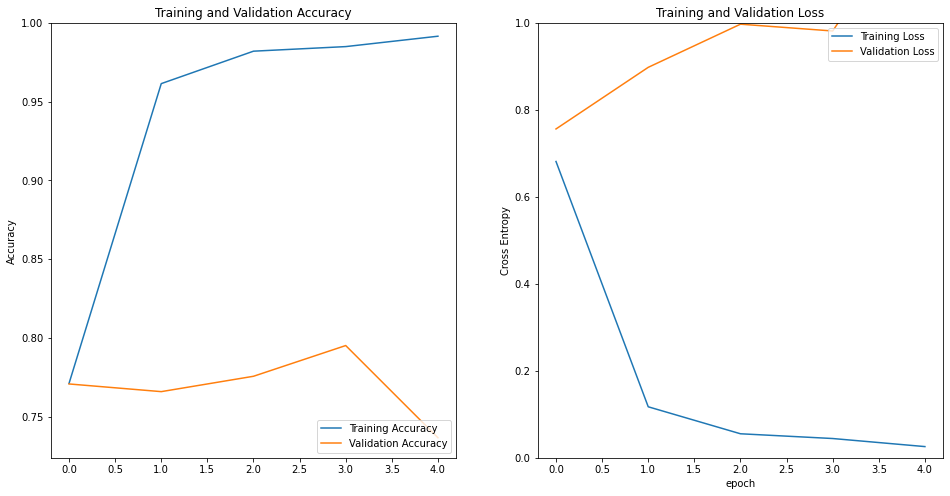

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [38]:
# Parameter 및 모델 구조 저장
model.save_weights(f'params.h5')
    
model_json = model.to_json()
with open(f"model.json", "w") as json_file : 
    json_file.write(model_json)

In [39]:
X_test.shape

(20480, 28, 28, 1)

In [40]:
result = model.predict_classes(X_test)

AttributeError: 'Model' object has no attribute 'predict_classes'

In [ ]:
result

In [ ]:
submission['digit'] = result

In [ ]:
submission

In [ ]:
submission.to_csv('./data/submission.csv', index=False)